In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

In [87]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

import physio

In [16]:
data_folder = Path('/home/samuel/Documents/physio_benchmark/data')

data_file = data_folder / 'human' / 'S00.txt'

# Open data

In [17]:
data = np.loadtxt(data_file)
data.shape
raw_ecg = data[:, 0]
raw_resp = data[:, 1]

srate = 1000
times = np.arange(raw_ecg.size) / srate

# compute ecg rpeak, resp cycle and rsa

In [30]:
ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_set='simple_ecg')
resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameter_set='human_airflow')

In [43]:
rsa_cycles, cyclic_cardiac_rate = physio.compute_rsa(resp_cycles, ecg_peaks, srate=10., two_segment=True)

299.237


In [44]:
rsa_cycles.head(5)

,amplitude,peak_value,trough_value
0,49.856201,107.673510,57.817309
1,38.346629,100.671141,62.324511
2,23.311951,97.534321,74.222370
3,46.687053,98.645499,51.958446
4,44.952469,96.700804,51.748335


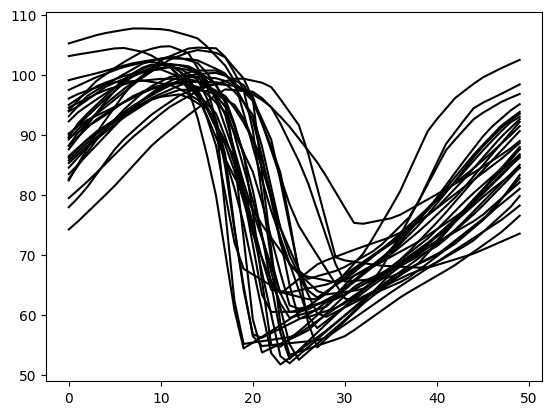

In [45]:
fig, ax = plt.subplots()
_ = ax.plot(cyclic_cardiac_rate.T, color='k')


# RSA on many subjects

In [114]:
num_subject = 15
points_per_cycle = 50


all_resp_cycles = []
all_rsa_cycles = []
all_cyclic_cardiac_rate = []
for subject_num in range(num_subject):
    subject_id = f'S{subject_num:02}'
    data_file = data_folder / 'human' / f'{subject_id}.txt'
    data = np.loadtxt(data_file)

    raw_ecg = data[:, 0]
    raw_resp = data[:, 1]

    srate = 1000
    times = np.arange(raw_ecg.size) / srate

    ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_set='simple_ecg')
    resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameter_set='human_airflow')
    rsa_cycles, cyclic_cardiac_rate = physio.compute_rsa(resp_cycles, ecg_peaks, srate=10., 
                                points_per_cycle=points_per_cycle, two_segment=True)
    rsa_cycles['subject_id'] = subject_id

    all_resp_cycles.append(resp_cycles)
    all_rsa_cycles.append(rsa_cycles)
    all_cyclic_cardiac_rate.append(cyclic_cardiac_rate)


In [115]:
resp_cycles.columns

Index(['inspi_index', 'expi_index', 'next_inspi_index', 'inspi_time',
       'expi_time', 'next_inspi_time', 'cycle_duration', 'inspi_duration',
       'expi_duration', 'cycle_freq', 'cycle_ratio', 'inspi_volume',
       'expi_volume', 'total_amplitude', 'inspi_amplitude', 'expi_amplitude',
       'total_volume'],
      dtype='object')

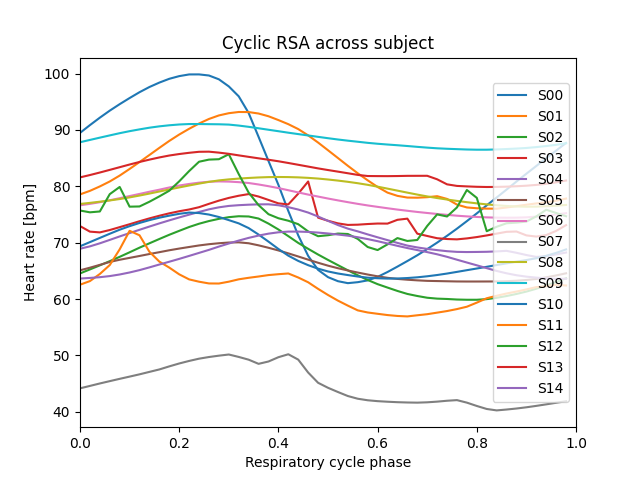

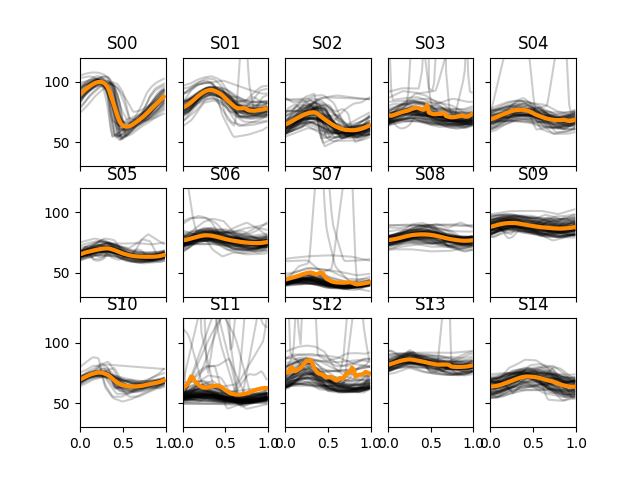

In [117]:
def make_figure_3b(ax, axs=None):


    one_cycle = np.arange(points_per_cycle) / points_per_cycle


    for subject_num in range(num_subject):
        subject_id = f'S{subject_num:02}'

        rsa_cycles = all_rsa_cycles[subject_num]
        cyclic_cardiac_rate = all_cyclic_cardiac_rate[subject_num]

        m = np.mean(cyclic_cardiac_rate, axis=0)
        if axs is not None:
            ax2 = axs.flatten()[subject_num]
            ax2.plot(one_cycle, cyclic_cardiac_rate.T, color='k', alpha=0.2)
            ax2.plot(one_cycle, m, color='darkorange', lw=3, )
            ax2.set_title(subject_id)

        ax.plot(one_cycle, m, label=subject_id)

    if axs is not None:
        axs[0, 0].set_ylim(30, 120)
        axs[0, 0].set_xlim(0, 1)

    ax.legend(loc='right')
    ax.set_xlabel('Respiratory cycle phase')
    ax.set_ylabel('Heart rate [bpm]')
    ax.set_title('Cyclic RSA across subject')
    ax.set_xlim(0, 1)

fig1, ax = plt.subplots()
fig2, axs = plt.subplots(ncols=5, nrows=3, sharex=True, sharey=True)


make_figure_3b(ax, axs)


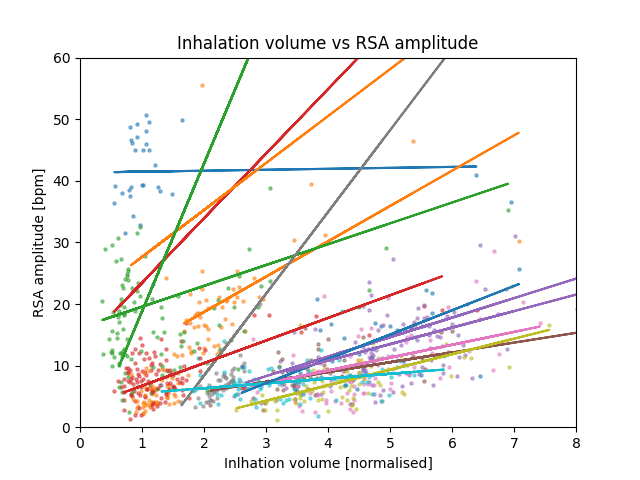

In [118]:
# %matplotlib inline
%matplotlib widget

def make_figure_3c(ax):
    for subject_num in range(num_subject):
        resp_cycles = all_resp_cycles[subject_num]
        rsa_cycles = all_rsa_cycles[subject_num]

        x, y = resp_cycles['inspi_volume'].values, rsa_cycles['amplitude'].values

        x = x / np.std(x)

        ax.scatter(x, y, s=5, alpha=0.5)

        res = scipy.stats.linregress(x, y)

        y_pred = x * res.slope + res.intercept
        ax.plot(x, y_pred)
        


    ax.set_ylim(0, 60.)
    ax.set_xlim(0, 8.)

    ax.set_xlabel('Inlhation volume [normalised]')
    ax.set_ylabel('RSA amplitude [bpm]')
    ax.set_title('Inhalation volume vs RSA amplitude')

fig, ax = plt.subplots()
make_figure_3c(ax)

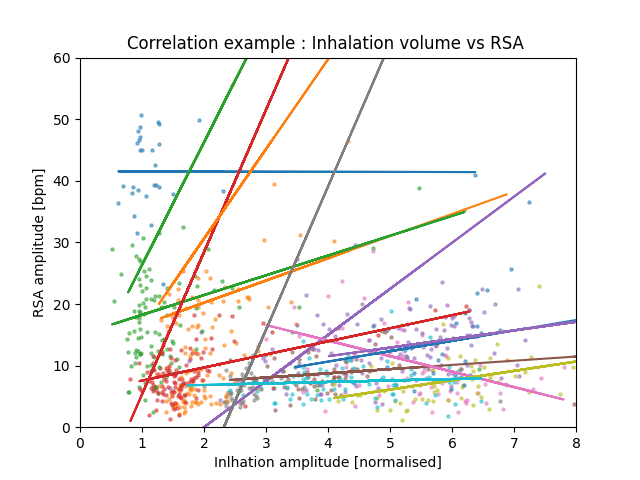

In [119]:
def make_figure_3d(ax):
    for subject_num in range(num_subject):
        resp_cycles = all_resp_cycles[subject_num]
        rsa_cycles = all_rsa_cycles[subject_num]

        x, y = resp_cycles['inspi_amplitude'].values, rsa_cycles['amplitude'].values

        x = x / np.std(x)

        ax.scatter(x, y, s=5, alpha=0.5)

        res = scipy.stats.linregress(x, y)

        y_pred = x * res.slope + res.intercept
        ax.plot(x, y_pred)
        


    ax.set_ylim(0, 60.)
    ax.set_xlim(0, 8.)

    ax.set_xlabel('Inlhation amplitude [normalised]')
    ax.set_ylabel('RSA amplitude [bpm]')
    ax.set_title('Correlation example : Inhalation volume vs RSA ')

fig, ax = plt.subplots()
make_figure_3d(ax)

In [108]:
def make_figure_3a(ax):
    return

# make final figure3

In [110]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

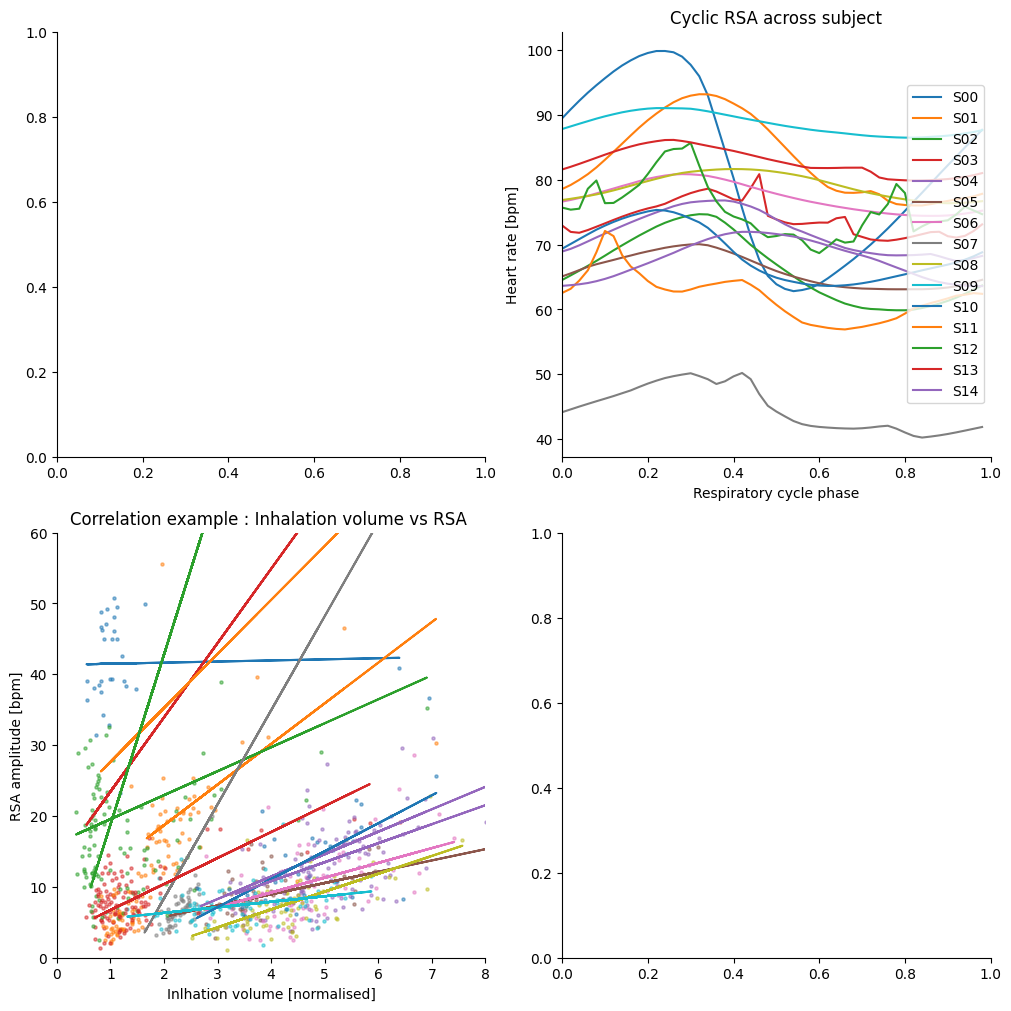

In [112]:
%matplotlib inline
fig = plt.figure(layout="constrained", figsize=(10, 10))
gs = plt.GridSpec(nrows=2, ncols=2, figure=fig)


ax = fig.add_subplot(gs[0, 0])
simpleaxis(ax)
make_figure_3a(ax)

ax = fig.add_subplot(gs[0, 1])
simpleaxis(ax)
make_figure_3b(ax)

ax = fig.add_subplot(gs[1, 0])
simpleaxis(ax)
make_figure_3c(ax)


ax = fig.add_subplot(gs[1, 1])
simpleaxis(ax)
make_figure_3d(ax)


fig.savefig('figure3.png')